#### Designing a time-stepper model for Fitzhugh Nagumo- Multiparameter

In [1]:
import jax.numpy as jnp
import numpy as np
import numpy.random as npr
from jax import jit, grad, vmap
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from functools import partial
from jax import jacfwd, jacrev
import jax.nn as jnn
import math
from jax import random
import jax
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from flax import linen as nn
import sklearn.metrics

import argparse
import os
import time
from termcolor import colored
from scipy.io import loadmat
import scipy.io as io
import pickle

import sys
sys.path.append("../..")

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

# Check where gpu is enable or not
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
cluster = False
save = True

In [3]:
if cluster == True:
    parser = argparse.ArgumentParser()
    parser.add_argument('-seed', dest='seed', type=int, default=0, help='Seed number.')
    args = parser.parse_args()

    # Print all the arguments
    for arg in vars(args):
        print(f'{arg}: {getattr(args, arg)}')

    seed = args.seed

if cluster == False:
    seed = 0 # Seed number.

if save == True:
    resultdir = os.path.join(os.getcwd(), 'Results')
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

if save == True and cluster == True:
    orig_stdout = sys.stdout
    q = open(os.path.join(resultdir, 'outputs.txt'), 'w')
    sys.stdout = q
    print ("------START------")

print('seed = '+str(seed))

seed = 0


In [4]:
np.random.seed(seed)
key = 1234 #random.PRNGKey(seed)

In [5]:
# Load the data

data = loadmat('../data/multiparameter/data_FHN_BF.mat')

# Convert NumPy arrays to PyTorch tensors
inputs1_train = jnp.array(data['U1_train_branch'])[:,0:200]
inputs2_train = jnp.array(data['U2_train_branch'])[:,0:200]
input_param = jnp.array(data['U2_train_branch'])[:,200:201]
inputs_train = jnp.concat([inputs1_train,inputs2_train,input_param], axis = -1)
outputs1_train = jnp.array(data['V1_train_out'])
outputs2_train = jnp.array(data['V2_train_out'])

inputs1_test = jnp.array(data['U1_test_branch'])[:,0:200]
inputs2_test = jnp.array(data['U2_test_branch'])[:,0:200]
input_param = jnp.array(data['U2_test_branch'])[:,200:201]
inputs_test = jnp.concat([inputs1_test,inputs2_test,input_param], axis = -1)

outputs1_test = jnp.array(data['V1_test_out'])
outputs2_test = jnp.array(data['V2_test_out'])

grid = jnp.array(data['Ytrain_trunk'])

# Check the shapes of the subsets
print("grid:", grid.shape)
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of outputs1_train:", outputs1_train.shape)
print("Shape of outputs1_test:", outputs1_test.shape)
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs2_train:", outputs2_train.shape)
print("Shape of outputs2_test:", outputs2_test.shape)
print('#'*100)

2024-11-27 22:24:52.746800: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


grid: (200, 1)
Shape of inputs_train: (16000, 401)
Shape of outputs1_train: (16000, 200)
Shape of outputs1_test: (1280, 200)
Shape of inputs_train: (16000, 401)
Shape of inputs_test: (1280, 401)
Shape of outputs2_train: (16000, 200)
Shape of outputs2_test: (1280, 200)
####################################################################################################


In [6]:
# Initialize the Glorot (Xavier) normal distribution for weight initialization
initializer = jax.nn.initializers.glorot_normal()

def init_glorot_params(layer_sizes, key = random.PRNGKey(seed)):
    """
    Initialize the parameters of the neural network using Glorot (Xavier) initialization.

    Args:
    layer_sizes (list): List of integers representing the size of each layer.
    key (PRNGKey): Random number generator key for reproducibility.

    Returns:
    list: List of tuples, each containing weights and biases for a layer.
    """
    return [(initializer(key, (m, n), jnp.float32), jnp.zeros(n))
            for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

def BranchNet(params, x):
    """
    Implement the branch network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (array): Input to the branch network.

    Returns:
    array: Output of the branch network.
    """
    def single_forward(params, x):
        for w, b in params:
            outputs = jnp.dot(x, w) + b
            x = jnn.silu(outputs)
        return outputs

    return vmap(partial(single_forward, params))(x)

def TrunkNet(params, x):
    """
    Implement the trunk network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (float): First input to the trunk network.
    t (float): Second input to the trunk network.

    Returns:
    array: Output of the trunk network.
    """
    inputs = jnp.array(x)
    for w, b in params:
        outputs = jnp.dot(x, w) + b
        x = jnn.silu(outputs)
    return outputs

@jit
def DeepONet(params, branch_inputs, trunk_inputs):
    """
    Implement the complete DeepONet architecture.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.

    Returns:
    array: Output of the DeepONet.
    """
    params_branch, params_trunk = params
    branch_outputs = lambda x: BranchNet(params_branch, x)
    b_out = branch_outputs(branch_inputs)
    trunk_output = lambda y: TrunkNet(params_trunk, y)
    t_out = trunk_output(trunk_inputs)
    results1 = jnp.einsum('ik, lk -> il',b_out[:,0:p], t_out[:,0:p])
    results2 = jnp.einsum('ik, lk -> il',b_out[:,p:2*p], t_out[:,p:2*p])
    return results1, results2

# network parameters.
p = 300 # Number of output neurons in both the branch and trunk net outputs.
nx = 401
input_neurons_branch = nx # m
input_neurons_trunk = 1

layer_sizes_b = [input_neurons_branch] + [100]*6 + [2*p]
layer_sizes_t = [input_neurons_trunk] + [100]*6 + [2*p]

params_branch = init_glorot_params(layer_sizes=layer_sizes_b)
params_trunk = init_glorot_params(layer_sizes=layer_sizes_t)

params= (params_branch, params_trunk)

def objective(params, branch_inputs, trunk_inputs, target_values1, target_values2):
    """
    Define the objective function (loss function) for training.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values to compare against.

    Returns:
    float: Mean squared error loss.
    """
    predictions1, predictions2 = DeepONet(params, branch_inputs, trunk_inputs)
    loss_mse = jnp.mean((predictions1 - target_values1)**2) + jnp.mean((predictions2 - target_values2)**2)
    return loss_mse


# Adam optimizer
@jit
def resnet_update(params, branch_input, trunk_inputs, target_values1, target_values2, opt_state):
    """
    Compute the gradient for a batch and update the parameters.

    Args:
    params (tuple): Current network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values.
    opt_state: Current state of the optimizer.

    Returns:
    tuple: Updated parameters, updated optimizer state, and current loss value.
    """
    value, grads = value_and_grad(objective)(params, branch_input, trunk_inputs, target_values1, target_values2)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Initialize the Adam optimizer
opt_init, opt_update, get_params = adam(step_size=1e-3, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)

bs = 15000 #batch size
iteration_list, loss_list, test_loss_list = [], [], []
iteration = 0

n_epochs = 100000
num_samples = len(inputs_train)

In [7]:
def save_model_params(params, resultdir, filename='model_params.pkl'):
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

    save_path = os.path.join(resultdir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(params, f)

def load_model_params(resultdir, filename='model_params.pkl'):
    load_path = os.path.join(resultdir, filename)
    with open(load_path, 'rb') as f:
        params = pickle.load(f)
    return params

# Saving
if save:
    save_model_params(params, resultdir)

# Loading (uncomment when needed)
# model_params = load_model_params(resultdir)

Saved initial model at iteration 0
New best model saved at iteration 0 with test MSE: 0.6383886
Iteration:   0, Train loss: 0.6383886, Test loss: 0.6383886, Best test loss: 0.6383886, Time: 6.78
New best model saved at iteration 1000 with test MSE: 0.0768184
Iteration: 1000, Train loss: 0.0768184, Test loss: 0.0768184, Best test loss: 0.0768184, Time: 11.74
New best model saved at iteration 2000 with test MSE: 0.0303588
Iteration: 2000, Train loss: 0.0303588, Test loss: 0.0303588, Best test loss: 0.0303588, Time: 16.67
New best model saved at iteration 3000 with test MSE: 0.0146963
Iteration: 3000, Train loss: 0.0146963, Test loss: 0.0146963, Best test loss: 0.0146963, Time: 21.65
New best model saved at iteration 4000 with test MSE: 0.0140676
Iteration: 4000, Train loss: 0.0140676, Test loss: 0.0140676, Best test loss: 0.0140676, Time: 26.64
New best model saved at iteration 5000 with test MSE: 0.0139026
Iteration: 5000, Train loss: 0.0139026, Test loss: 0.0139026, Best test loss: 0.0

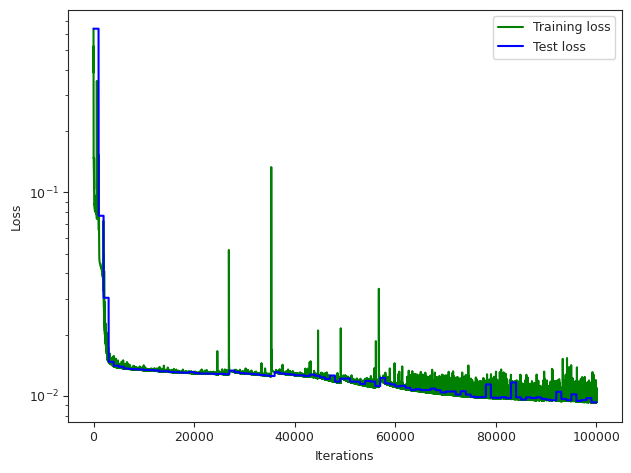

Time (sec) to complete:
516.1288440227509


<Figure size 640x480 with 0 Axes>

In [8]:
## Training of DeepONet
start = time.time() # start time of training
best_test_mse = float('inf')  # Initialize with infinity

# Save initial model at 0th iteration
save_model_params(params, resultdir, filename='model_params_best.pkl')
print("Saved initial model at iteration 0")

for iteration in range(n_epochs):
    indices = jax.random.permutation(jax.random.PRNGKey(0), num_samples)
    batch_index = indices[0:bs]
    inputs_train_shuffled = inputs_train[batch_index]
    outputs1_train_shuffled = outputs1_train[batch_index]
    outputs2_train_shuffled = outputs2_train[batch_index]
    target_values1 = outputs1_train_shuffled
    target_values2 = outputs2_train_shuffled
    branch_inputs = inputs_train_shuffled
    trunk_inputs = grid
    params, opt_state, value = resnet_update(params, branch_inputs, trunk_inputs, target_values1, target_values2, opt_state)

    if iteration % 1000 == 0:
        params_branch, params_trunk = params
        predictions1, predictions2 = DeepONet(params, branch_inputs, trunk_inputs)
        test_mse = jnp.mean((predictions1 - target_values1)**2) + jnp.mean((predictions2 - target_values2)**2)

        # Compare current test error with the best so far
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            # Save the model as it's the best so far
            save_model_params(params, resultdir, filename='model_params_best.pkl')
            print(f"New best model saved at iteration {iteration} with test MSE: {test_mse:.7f}")

        finish = time.time() - start
        print(f"Iteration: {iteration:3d}, Train loss: {objective(params, branch_inputs, trunk_inputs, target_values1, target_values2):.7f}, Test loss: {test_mse:.7f}, Best test loss: {best_test_mse:.7f}, Time: {finish:.2f}")

    iteration_list.append(iteration)
    loss_list.append(objective(params, branch_inputs, trunk_inputs, target_values1, target_values2))
    test_loss_list.append(test_mse)

if save:
    np.save(os.path.join(resultdir, 'iteration_list.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir, 'loss_list.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir, 'test_loss_list.npy'), np.asarray(test_loss_list))

# Plotting code remains the same
plt.figure()
plt.plot(iteration_list, loss_list, 'g', label='Training loss')
plt.plot(iteration_list, test_loss_list, '-b', label='Test loss')
plt.yscale("log")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

if save:
    plt.savefig(os.path.join(resultdir, 'loss_plot.pdf'))

# end timer
finish = time.time() - start
print("Time (sec) to complete:\n" + str(finish))

Loaded best model parameters
(1280, 401)
TEST SAMPLE 1
Component-1 Rel. L2 Error = 0.0214, R2 score = 0.9994
Component-2 Rel. L2 Error = 0.0217, R2 score = 0.9993
######################################################################################################################################################################################################################################
TEST SAMPLE 501
Component-1 Rel. L2 Error = 0.0055, R2 score = 1.0
Component-2 Rel. L2 Error = 0.0201, R2 score = 0.9996
######################################################################################################################################################################################################################################
TEST SAMPLE 1001
Component-1 Rel. L2 Error = 0.0261, R2 score = 0.9981
Component-2 Rel. L2 Error = 0.0287, R2 score = 0.9971
#################################################################################################################################

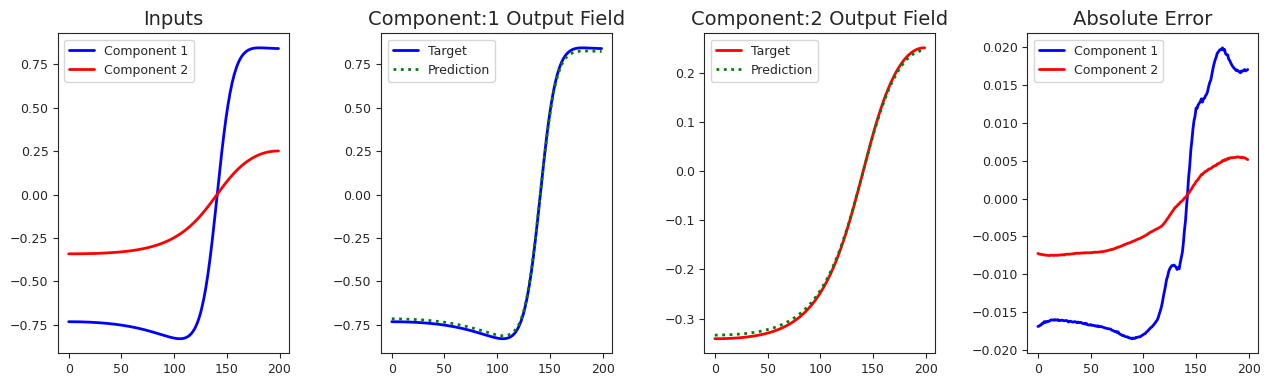

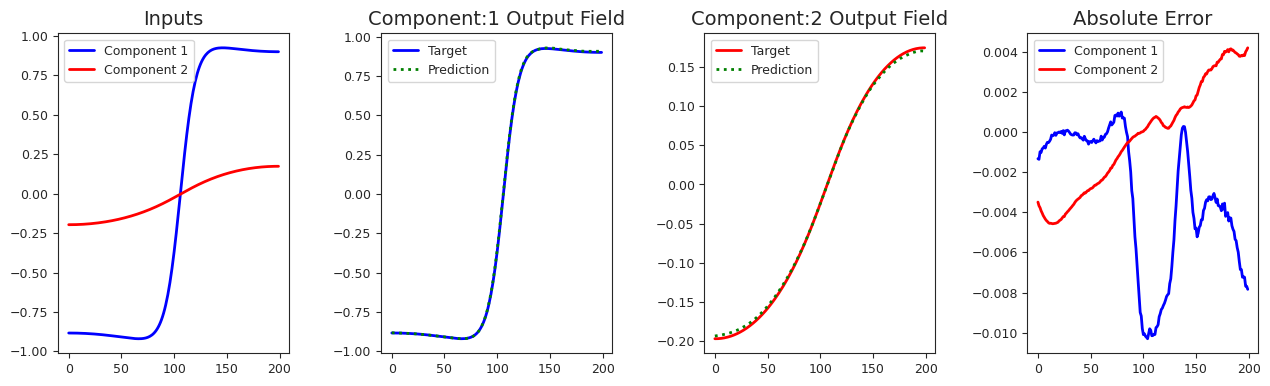

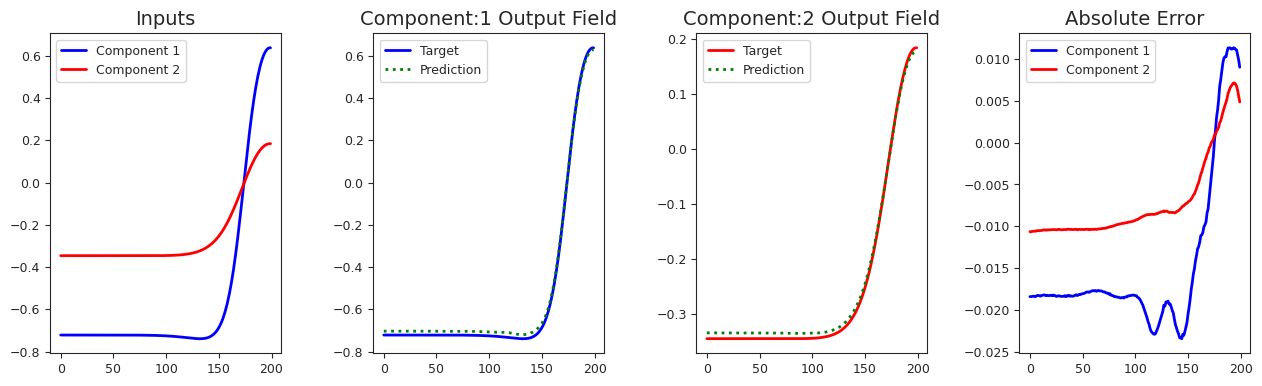

In [9]:
# params_branch, params_trunk = params
# Load the best model parameters
best_params = load_model_params(resultdir, filename='model_params_best.pkl')
print("Loaded best model parameters")

# Predictions
mse_list = []

branch_inputs = inputs_test
print(branch_inputs.shape)

trunk_inputs = grid
prediction1, prediction2 = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval) 
input_test1 = inputs_test[:,0:200]
input_test2 = inputs_test[:,200:400]
parameter = inputs_test[:,400:401]
save_dict = {'u1_test': input_test1, 'u2_test': input_test2, 'eps': parameter, 'v1_pred': prediction1, 'v2_pred': prediction2, \
             'v1_target': outputs1_test, 'v2_target': outputs2_test}

io.savemat(resultdir+'/pred.mat', save_dict)
# Plotting all the results on -1 to 1 scale for better understanding
for i in range(inputs_test.shape[0]):

    branch_inputs = inputs_test[i].reshape(1, nx) 
    trunk_inputs = grid # (neval, 1) 
    
    prediction1_i, prediction2_i = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval)
    target1_i = outputs1_test[i]
    target2_i = outputs2_test[i]
    mse_i = np.mean((prediction1_i - target1_i)**2) + np.mean((prediction2_i - target2_i)**2)
    mse_list.append(mse_i.item())
  
    if i % 500 == 0:
        print(colored('TEST SAMPLE '+str(i+1), 'red'))

        r2score = metrics.r2_score(target1_i.flatten(), prediction1_i.flatten())
        relerror = np.linalg.norm(target1_i- prediction1_i) / np.linalg.norm(target1_i)
        r2score = float('%.4f'%r2score)
        relerror = float('%.4f'%relerror)
        print('Component-1 Rel. L2 Error = '+str(relerror)+', R2 score = '+str(r2score))

        r2score = metrics.r2_score(target2_i.flatten(), prediction2_i.flatten())
        relerror = np.linalg.norm(target2_i- prediction2_i) / np.linalg.norm(target2_i)
        r2score = float('%.4f'%r2score)
        relerror = float('%.4f'%relerror)
        print('Component-2 Rel. L2 Error = '+str(relerror)+', R2 score = '+str(r2score))

        fig = plt.figure(figsize=(15, 4))

        # Adjust subplot parameters for better spacing
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

        # Input plot
        ax = fig.add_subplot(1, 4, 1)
        plt.plot(inputs_test[i,0:200], color='blue', linewidth=2)
        plt.plot(inputs_test[i,200:400], color='red', linewidth=2)
        plt.title('Inputs', fontsize=14)
        plt.legend(['Component 1', 'Component 2'])

        # Output plot
        ax = fig.add_subplot(1, 4, 2)
        target1 = target1_i.reshape(grid.shape[0])
        prediction1 = prediction1_i.reshape(grid.shape[0])
        plt.plot(target1, color='blue', linewidth=2)
        plt.plot(prediction1, color='green', linewidth=2, linestyle = 'dotted')
        plt.title('Component:1 Output Field', fontsize=14)
        plt.legend(['Target', 'Prediction'])

        ax = fig.add_subplot(1, 4, 3)
        target2 = target2_i.reshape(grid.shape[0])
        prediction2 = prediction2_i.reshape(grid.shape[0])
        plt.plot(target2, color='red', linewidth=2)
        plt.plot(prediction2, color='green', linewidth=2, linestyle = 'dotted')
        plt.title('Component:2 Output Field', fontsize=14)
        plt.legend(['Target', 'Prediction'])

        # Error plot
        ax = fig.add_subplot(1, 4, 4)
        error1 = target1 - prediction1
        error2 = target2 - prediction2
        plt.plot(error1, color='blue', linewidth=2)
        plt.plot(error2, color='red', linewidth=2)
        #plt.yscale("log")  
        plt.legend(['Component 1', 'Component 2'])
        plt.title('Absolute Error', fontsize=14)

        print(colored('#'*230, 'green'))

mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test :\n", mse)